In [2]:
# TODO


# Prediction: Not based on most likely value and then look up, but rather directly take value 
# Generates a prediction for the full seq len every time 

# Later: Positional embedding with different layer type/ computation? 



In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt

from Helpers import create_rolling_windows 

# Dataset

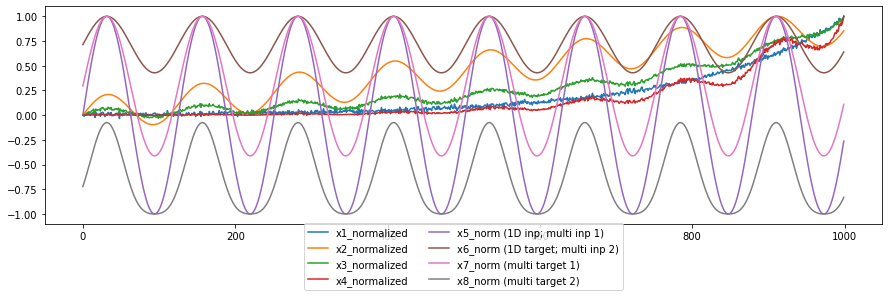

In [2]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8
x6 = x5 * 0.2 + 0.4
x7 = x5 + x6 
x8 = x5 * x6 - 0.5

x1_factor = np.max(np.abs(x1))
x2_factor = np.max(np.abs(x2))
x3_factor = np.max(np.abs(x3))
x4_factor = np.max(np.abs(x4))
x5_factor = np.max(np.abs(x5))
x6_factor = np.max(np.abs(x6))
x7_factor = np.max(np.abs(x7))
x8_factor = np.max(np.abs(x8))


# normalize per time series
x1_normalized = x1 / x1_factor
x2_normalized = x2 / x2_factor
x3_normalized = x3 / x3_factor
x4_normalized = x4 / x4_factor
x5_normalized = x5 / x5_factor
x6_normalized = x6 / x6_factor
x7_normalized = x7 / x7_factor
x8_normalized = x8 / x8_factor


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.plot(range(len(x5_normalized)), x5_normalized, label='x5_norm (1D inp; multi inp 1)')
plt.plot(range(len(x6_normalized)), x6_normalized, label='x6_norm (1D target; multi inp 2)')
plt.plot(range(len(x7_normalized)), x7_normalized, label='x7_norm (multi target 1)')
plt.plot(range(len(x8_normalized)), x8_normalized, label='x8_norm (multi target 2)')
plt.legend(loc = "center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [3]:
batch_size = 128
sequence_length = 20

Shape surrogate pairs: (980, 2, 21)


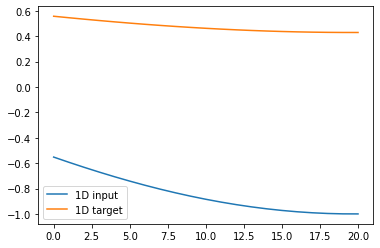

Shape surrogate quadrupels: (980, 4, 21)


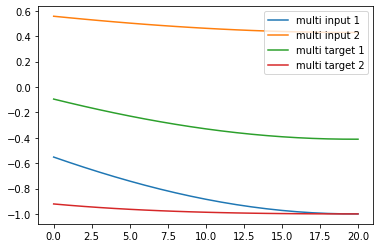

In [4]:
# Create windowed data 

# timeseries_dataset_from_array(data=x6_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)

# create window size as seq len + 1 for easy cutting later on 
window_size = sequence_length + 1

# window size 21
x5_windowed = create_rolling_windows(x5_normalized,window_size) # 1D input; multi input 1
x6_windowed = create_rolling_windows(x6_normalized,window_size) # 1D target; multi input 2
x7_windowed = create_rolling_windows(x7_normalized,window_size) # multi target 1
x8_windowed = create_rolling_windows(x8_normalized,window_size) # multi target 2 


surrogate_pairs = np.array([x5_windowed, x6_windowed])
surrogate_pairs = np.swapaxes(surrogate_pairs,0,1)
print("Shape surrogate pairs: " + str(surrogate_pairs.shape))
plt.plot(surrogate_pairs[200][0], label = "1D input") 
plt.plot(surrogate_pairs[200][1], label = "1D target")
plt.legend()
plt.show()

surrogate_quadruples = np.array([x5_windowed, x6_windowed, x7_windowed, x8_windowed])
surrogate_quadruples = np.swapaxes(surrogate_quadruples,0,1)
print("Shape surrogate quadrupels: " + str(surrogate_quadruples.shape))
plt.plot(surrogate_quadruples[200][0], label = "multi input 1") 
plt.plot(surrogate_quadruples[200][1], label = "multi input 2")
plt.plot(surrogate_quadruples[200][2], label = "multi target 1")
plt.plot(surrogate_quadruples[200][3], label = "multi target 2")
plt.legend()
plt.show()



In [5]:
val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_pairs)
num_val_samples = int(val_frac * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

980 total pairs
686 training pairs
147 validation pairs
147 test pairs


In [6]:
# Split pairs into inp and target 
train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
val_inp_seqs = [pair[0] for pair in val_pairs]
val_target_seqs = [pair[1] for pair in val_pairs]


print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))
print(np.shape(val_inp_seqs))
print(np.shape(val_target_seqs))


(686, 21)
(686, 21)
(147, 21)
(147, 21)


In [7]:
        
def make_dataset(input_seqs,target_seqs):
    
    input_seqs = np.array(input_seqs).astype(float)
    target_seqs = np.array(target_seqs).astype(float)
    
    # Create dataset with inp sequence <-> target sequence pairs (both have length sequence_length)
    dataset = tf.data.Dataset.from_tensor_slices((input_seqs, target_seqs)) # tuple makes sure that inp matches correct target

    # batch 
    dataset = dataset.batch(batch_size)
    
    # format input/ outputs omitting last elem for decoder input and skipping first elem for target 
    # idea: instead of "word by word", show everything and do not omit first or last 
    dataset = dataset.map(format_dataset)
    
    return dataset.shuffle(2048).prefetch(16).cache()



def format_dataset(inp, target):
    
    
    # transformer architecture -> proceed word by word
    # full target sequence for input (i.e. 20)
    # 0 to N for decoder input (i.e. 20)
    # 1 to N-1 for target -> shifted by one (i.e. 20)
    # TODO: Make rolling windows more clever, i.e. no need to cut inp
    
    return ({"encoder_inputs": inp[:, :-1], "decoder_inputs": target[:, :-1],}, target[:, 1:])
    #return ({"encoder_inputs": inp, "decoder_inputs": target[:, :-1],}, target)
    #return ({"encoder_inputs": inp, "decoder_inputs": target}, target)
    
    # orig
    # return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])
    

train_ds = make_dataset(train_inp_seqs,train_target_seqs)
val_ds = make_dataset(val_inp_seqs,val_target_seqs)

In [8]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


# Basic model - 1D

In [ ]:
X = np.array(train_inp_seqs)
Y = np.array(train_target_seqs)

tf.keras.backend.clear_session()

basic_model = keras.models.Sequential()
basic_model.add(layers.Dense(200, input_dim=200, activation='relu')) # relu
basic_model.add(layers.Dense(200, activation='relu')) # relu
basic_model.add(layers.Dense(200, activation='sigmoid')) # sigmoid
# compile the keras model
basic_model.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
basic_model.summary()
# fit the keras model on the dataset
basic_model.fit(X, Y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = basic_model.evaluate(X, Y)
print('Accuracy: %.2f' % (accuracy*100))



In [ ]:
val_inp = np.array([val_inp_seqs[80]])
val_true = np.array([val_target_seqs[80]])
val_pred = basic_model.predict(val_inp)


plt.plot(val_inp[0], label = "validation input")
plt.plot(val_true[0], label = "validation ground truth")
plt.plot(val_out[0], label = "prediction")
plt.legend()
plt.show()


# Basic Model - Multi dimensional

In [ ]:
surrogate_quadruples

val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_quadruples)
num_val_samples = int(val_frac * len(surrogate_quadruples))
num_train_samples = len(surrogate_quadruples) - 2 * num_val_samples
train_quads = surrogate_quadruples[:num_train_samples]
val_quads = surrogate_quadruples[num_train_samples : num_train_samples + num_val_samples]
test_quads = surrogate_quadruples[num_train_samples + num_val_samples :]

print(f"{len(surrogate_quadruples)} total quads")
print(f"{len(train_quads)} training quads")
print(f"{len(val_quads)} validation quads")
print(f"{len(test_quads)} test quads")






In [ ]:
X = np.array(train_quads[:,0:2,:])
X = X.reshape(X.shape[0],-1)
Y = np.array(train_quads[:,2:,:])
Y = Y.reshape(Y.shape[0],-1)

tf.keras.backend.clear_session()

basic_model_multi = keras.models.Sequential()
basic_model_multi.add(layers.Dense(400, input_dim = X.shape[1], activation='tanh')) # relu
basic_model_multi.add(layers.Dense(400, activation='tanh')) # relu
basic_model_multi.add(layers.Dense(400, activation='tanh')) # sigmoid
# compile the keras model
basic_model_multi.compile(loss="mse", optimizer='adam', metrics=['accuracy'])
basic_model_multi.summary()
# fit the keras model on the dataset
basic_model_multi.fit(X, Y, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = basic_model_multi.evaluate(X, Y)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# use from train dataset 
if False:
    val_inp = np.array([X[200,:]])
    val_true = np.array([Y[200,:]])
# use actual validation 
else:
    val_inp = np.array(val_quads[:,0:2,:])
    val_inp = val_inp.reshape(val_inp.shape[0],-1)
    val_inp = np.array([val_inp[100,:]])
    val_true = np.array(val_quads[:,2:4,:])
    val_true = val_true.reshape(val_true.shape[0],-1)
    val_true = np.array([val_true[100,:]])
    
val_out = basic_model_multi(val_inp) # predict 
    

plt.plot(val_inp[0][0:200], label = "validation input 1")
plt.plot(val_inp[0][200:400], label = "validation input 2")
plt.plot(val_true[0][0:200], label = "validation ground truth 1")
plt.plot(val_true[0][200:400], label = "validation ground truth 2")
plt.plot(val_out[0][0:200], label = "prediction 1")
plt.plot(val_out[0][200:400], label = "prediction 2")
plt.legend()
plt.show()

# Transformer Model

In [27]:


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="tanh"), layers.Dense(embed_dim),] # activation relu 
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="float64") # dtype int32
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        
        print("Encoder Shape")
        print(self.layernorm_2(proj_input + proj_output))
        return self.layernorm_2(proj_input + proj_output)

    
    

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        
        embedded_positions = self.position_embeddings(positions)
        
        
        #return embedded_tokens + embedded_positions # original
        return tf.expand_dims(inputs, axis=2) + embedded_positions # add actual numbers + positional embedding
        
        
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    
    
    

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="tanh"), layers.Dense(embed_dim),] # activation relu
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="float64") # dtype int32
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        
        print("Decoder Shape")
        print(self.layernorm_3(out_2 + proj_output))
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="float64") # dtype int32
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)



In [42]:
embed_dim = 1 #256
latent_dim = 2048
num_heads = 8


encoder_inputs = keras.Input(shape=(None,), dtype="float64", name="encoder_inputs")
x_encoder = PositionalEmbedding(sequence_length, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x_encoder)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="float64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x_decoder = PositionalEmbedding(sequence_length, embed_dim)(decoder_inputs)
x_decoder = TransformerDecoder(embed_dim, latent_dim, num_heads)(x_decoder, encoded_seq_inputs)
x_decoder = layers.Dropout(0.5)(x_decoder)

# decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x) # orig
#decoder_outputs = layers.Dense(sequence_length, activation="softmax")(x_decoder)
decoder_outputs = layers.Dense(20, activation="tanh")(x_decoder) 




#decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])



transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)



Encoder Shape
Tensor("transformer_encoder_2/layer_normalization_11/add:0", shape=(None, None, 1), dtype=float32)
Decoder Shape
Tensor("transformer_decoder_2/layer_normalization_14/add:0", shape=(None, None, 1), dtype=float32)
Decoder Shape
Tensor("model_5/transformer_decoder_2/layer_normalization_14/add:0", shape=(None, None, 1), dtype=float32)


In [43]:
#error_sq = tf.math.squared_difference(y_pred, y_true)

def custom_mse(y_true, y_pred):
    
    print(y_true)
    print(y_pred)
    
    #squared_difference = tf.square(y_true - y_pred[:,0,:])
    
    squared_difference = tf.square(y_true - y_pred[:,:,-1]) # last entry of each
    
 
    
    
    return tf.reduce_mean(squared_difference) 


In [55]:
epochs = 300  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss=custom_mse, metrics=["accuracy"] # sparse_categorical_crossentropy # mse
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_4 (Positio (None, None, 1)      20          encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_2 (Transfor (None, None, 1)      6206        positional_embedding_4[0][0]     
________________________________________________________________________________________

6/6 [==============================] - 1s 94ms/step - loss: 0.1037 - accuracy: 0.0000e+00 - val_loss: 0.0528 - val_accuracy: 0.0000e+00
Epoch 38/300
6/6 [==============================] - 1s 106ms/step - loss: 0.1016 - accuracy: 0.0000e+00 - val_loss: 0.0522 - val_accuracy: 0.0000e+00
Epoch 39/300
6/6 [==============================] - 1s 99ms/step - loss: 0.1017 - accuracy: 0.0000e+00 - val_loss: 0.0517 - val_accuracy: 0.0000e+00
Epoch 40/300
6/6 [==============================] - 1s 96ms/step - loss: 0.0973 - accuracy: 0.0000e+00 - val_loss: 0.0511 - val_accuracy: 0.0000e+00
Epoch 41/300
6/6 [==============================] - 1s 95ms/step - loss: 0.0960 - accuracy: 0.0000e+00 - val_loss: 0.0506 - val_accuracy: 0.0000e+00
Epoch 42/300
6/6 [==============================] - 1s 96ms/step - loss: 0.0940 - accuracy: 0.0000e+00 - val_loss: 0.0501 - val_accuracy: 0.0000e+00
Epoch 43/300
6/6 [==============================] - 1s 106ms/step - loss: 0.0928 - accuracy: 0.0000e+00 - val_loss: 0.

Epoch 92/300
6/6 [==============================] - 1s 87ms/step - loss: 0.0493 - accuracy: 0.0000e+00 - val_loss: 0.0390 - val_accuracy: 0.0000e+00
Epoch 93/300
6/6 [==============================] - 1s 90ms/step - loss: 0.0490 - accuracy: 0.0000e+00 - val_loss: 0.0390 - val_accuracy: 0.0000e+00
Epoch 94/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0490 - accuracy: 0.0000e+00 - val_loss: 0.0389 - val_accuracy: 0.0000e+00
Epoch 95/300
6/6 [==============================] - 1s 94ms/step - loss: 0.0491 - accuracy: 0.0000e+00 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 96/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0488 - accuracy: 0.0000e+00 - val_loss: 0.0388 - val_accuracy: 0.0000e+00
Epoch 97/300
6/6 [==============================] - 1s 90ms/step - loss: 0.0477 - accuracy: 0.0000e+00 - val_loss: 0.0387 - val_accuracy: 0.0000e+00
Epoch 98/300
6/6 [==============================] - 1s 90ms/step - loss: 0.0474 - accuracy: 0.0000e+00 - v

Epoch 147/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0420 - accuracy: 0.0000e+00 - val_loss: 0.0384 - val_accuracy: 0.0000e+00
Epoch 148/300
6/6 [==============================] - 1s 90ms/step - loss: 0.0419 - accuracy: 0.0000e+00 - val_loss: 0.0384 - val_accuracy: 0.0000e+00
Epoch 149/300
6/6 [==============================] - 1s 90ms/step - loss: 0.0419 - accuracy: 0.0000e+00 - val_loss: 0.0384 - val_accuracy: 0.0000e+00
Epoch 150/300
6/6 [==============================] - 1s 93ms/step - loss: 0.0419 - accuracy: 0.0000e+00 - val_loss: 0.0384 - val_accuracy: 0.0000e+00
Epoch 151/300
6/6 [==============================] - 1s 85ms/step - loss: 0.0418 - accuracy: 0.0000e+00 - val_loss: 0.0384 - val_accuracy: 0.0000e+00
Epoch 152/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0419 - accuracy: 0.0000e+00 - val_loss: 0.0384 - val_accuracy: 0.0000e+00
Epoch 153/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0417 - accuracy: 0.0000e

6/6 [==============================] - 1s 89ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0385 - val_accuracy: 0.0000e+00
Epoch 202/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0416 - accuracy: 0.0000e+00 - val_loss: 0.0385 - val_accuracy: 0.0000e+00
Epoch 203/300
6/6 [==============================] - 1s 94ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0385 - val_accuracy: 0.0000e+00
Epoch 204/300
6/6 [==============================] - 1s 93ms/step - loss: 0.0416 - accuracy: 0.0000e+00 - val_loss: 0.0385 - val_accuracy: 0.0000e+00
Epoch 205/300
6/6 [==============================] - 1s 95ms/step - loss: 0.0416 - accuracy: 0.0000e+00 - val_loss: 0.0385 - val_accuracy: 0.0000e+00
Epoch 206/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0385 - val_accuracy: 0.0000e+00
Epoch 207/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss

Epoch 256/300
6/6 [==============================] - 1s 94ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 257/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 258/300
6/6 [==============================] - 1s 90ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 259/300
6/6 [==============================] - 1s 93ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 260/300
6/6 [==============================] - 1s 94ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 261/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0415 - accuracy: 0.0000e+00 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 262/300
6/6 [==============================] - 1s 92ms/step - loss: 0.0415 - accuracy: 0.0000e

In [70]:

max_decoded_sequence_length = 20

def decode_sequence(input_sequence):
    decoded_sequence = np.zeros((max_decoded_sequence_length))
    for i in range(max_decoded_sequence_length):
        
        predictions = transformer.predict([np.array([input_sequence,]), np.array([decoded_sequence,])])       
        
        # verify idxs 
        sampled_token = np.max(predictions[0, i, i]) # idea: out of all seq predicted per token, take current token pred seq and from that take current token pred idx
        if i < max_decoded_sequence_length - 1:
            decoded_sequence[i+1] = sampled_token
    
    return np.append(decoded_sequence, sampled_token) # add last token 




(20,)


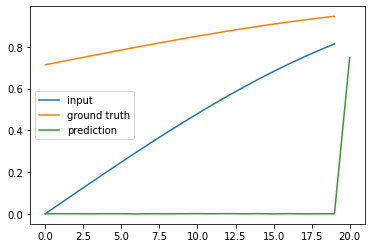

In [71]:
inp_seq = train_inp_seqs[0][:-1]
true_seq = train_target_seqs[0][:-1]
pred_seq = decode_sequence(inp_seq)

print(np.shape(inp_seq))

plt.plot(inp_seq, label = "input")
plt.plot(true_seq, label = "ground truth")
plt.plot(pred_seq, label = "prediction")
plt.legend()
plt.show()

In [ ]:
print(1/0)

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)